# `mini_data_lab` Tutorial (Analyzer + Visualizer)

# Tutorial — Using `penguins_data_lab` (Analyzer + Visualizer)

This tutorial shows a complete, small-scale data workflow on the **Palmer Penguins** dataset using the `penguins_data_lab` package.  
Each section briefly **explains what the called function does** and then shows a short code cell that uses it.

---

## 1) Setup

Choose **one** of the following:

### Option A — Virtual environment + install the package (recommended)
```bash
# from the repo root
python3 -m venv .venv
source .venv/bin/activate        # Windows: .venv\Scripts\activate
pip install -e .
```

### Option B — Regular setup (no venv)

```bash
pip install .
```


## 2) Load & Clean

### What the loader/cleaner does
- **`DataLoaderCleaner.load_penguins()`** loads the Palmer Penguins dataset from `seaborn` (no external files required). The raw data may contain missing values.
- **`DataLoaderCleaner.clean_penguins(df)`** prepares the data for analysis by:
  - dropping rows with missing values in essential columns (`bill_length_mm`, `bill_depth_mm`, `flipper_length_mm`, `body_mass_g`, `species`, `island`, `sex`);
  - casting string-like columns (`species`, `island`, `sex`) to **categorical** dtype (clearer grouping, less memory);
  - removing non-positive measurements in the numeric columns (biologically implausible values);
  - resetting the index after filtering.

In [41]:
import sys, os
sys.path.insert(0, os.path.abspath("src")) 

from penguins_data_lab.module_data_loader import DataLoaderCleaner
from penguins_data_lab.module_analyzer import Analyzer
from penguins_data_lab.module_visualizer import Visualizer

dlc = DataLoaderCleaner()
df = dlc.load_penguins()
df_clean = dlc.clean_penguins(df)
print(df.shape, '-> after cleaning:', df_clean.shape)
df_clean.head()

(344, 7) -> after cleaning: (333, 7)


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
4,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


## 3) Analyze (core Python + pandas/numpy)

### What the analyzer provides
The `Analyzer` class mixes **core Python control flow** (for/while, if/elif/else), **dicts/tuples**, and **pandas/numpy** for transparent analysis steps.

- **`Analyzer.summary_stats(df)`**  
  Returns standard descriptive statistics (`count`, `mean`, `std`, `min`, quartiles, `max`) for **numeric** columns only.


In [42]:
an = Analyzer()
an.summary_stats(df_clean).head()

,count,mean,std,min,25%,50%,75%,max
bill_length_mm,333.0,43.992793,5.468668,32.1,39.5,44.5,48.6,59.6
bill_depth_mm,333.0,17.164865,1.969235,13.1,15.6,17.3,18.7,21.5
flipper_length_mm,333.0,200.966967,14.015765,172.0,190.0,197.0,213.0,231.0
body_mass_g,333.0,4207.057057,805.215802,2700.0,3550.0,4050.0,4775.0,6300.0


- **`Analyzer.biggest_penguins_origin(df, metric="body_mass_g", group_by="island", top_k=10)`**  
  Picks the **top-k** penguins by a metric (default: body mass), then **counts how many** of those top birds come from each group (default: island).  
  Returns a `(counts_dict, top_subset_df)` pair so you can both inspect the counts and see the actual top-k rows.

In [43]:
# Biggest penguins' origin
counts, top10 = an.biggest_penguins_origin(df_clean, metric='body_mass_g', group_by='island', top_k=10)
counts

{'Biscoe': 10}

- **`Analyzer.manual_value_counts(df, column)`**  
  A pure-Python reimplementation of value counting using a **dict and a for-loop** (no `pandas.value_counts`). Good for demonstrating control flow/data structures explicitly.

In [44]:
# Manual value counts (dict + loop)
an.manual_value_counts(df_clean, 'species')

{'Adelie': 146, 'Chinstrap': 68, 'Gentoo': 119}

- **`Analyzer.find_extremes(df, value_col)`**  
  Manually computes the **minimum** and **maximum** of a numeric column via a loop (returns a `(min, max)` tuple). Shows branching logic without relying on pandas.

In [45]:
# Extremes with manual loop (lightest - heaviest)
an.find_extremes(df_clean, 'body_mass_g')

(2700.0, 6300.0)

- **`Analyzer.species_size_summary(df)`**  
  Builds a nested **dict** mapping each `species` to `{"mean_mass": ..., "mean_flipper": ...}` using explicit accumulation loops (sums + counts → means).

In [46]:
# Species size summary (dicts & tuples)
an.species_size_summary(df_clean)

{'Adelie': {'mean_mass': 3706.1643835616437,
  'mean_flipper': 190.1027397260274},
 'Chinstrap': {'mean_mass': 3733.0882352941176,
  'mean_flipper': 195.8235294117647},
 'Gentoo': {'mean_mass': 5092.436974789916,
  'mean_flipper': 217.23529411764707}}

- **`Analyzer.add_size_class(df, col="body_mass_g")`**  
  Adds a new categorical column `size_class` using **if/elif/else** thresholds:  
  `< 3500 → "small"`, `3500–4500 → "medium"`, `> 4500 → "large"`.  
  Returns a **copy** of the input with the new column.

In [47]:
# Add size class using if/elif/else
df_with_class = an.add_size_class(df_clean, col='body_mass_g')
df_with_class[['species','body_mass_g','size_class']].head()

,species,body_mass_g,size_class
0,Adelie,3750.0,medium
1,Adelie,3800.0,medium
2,Adelie,3250.0,small
3,Adelie,3450.0,small
4,Adelie,3650.0,medium


## 4) Visualize

### What the visualizer draws
- **`Visualizer.plot_distributions(df)`**  
  Four histograms (one for each core numeric feature) to see overall spread and shape.

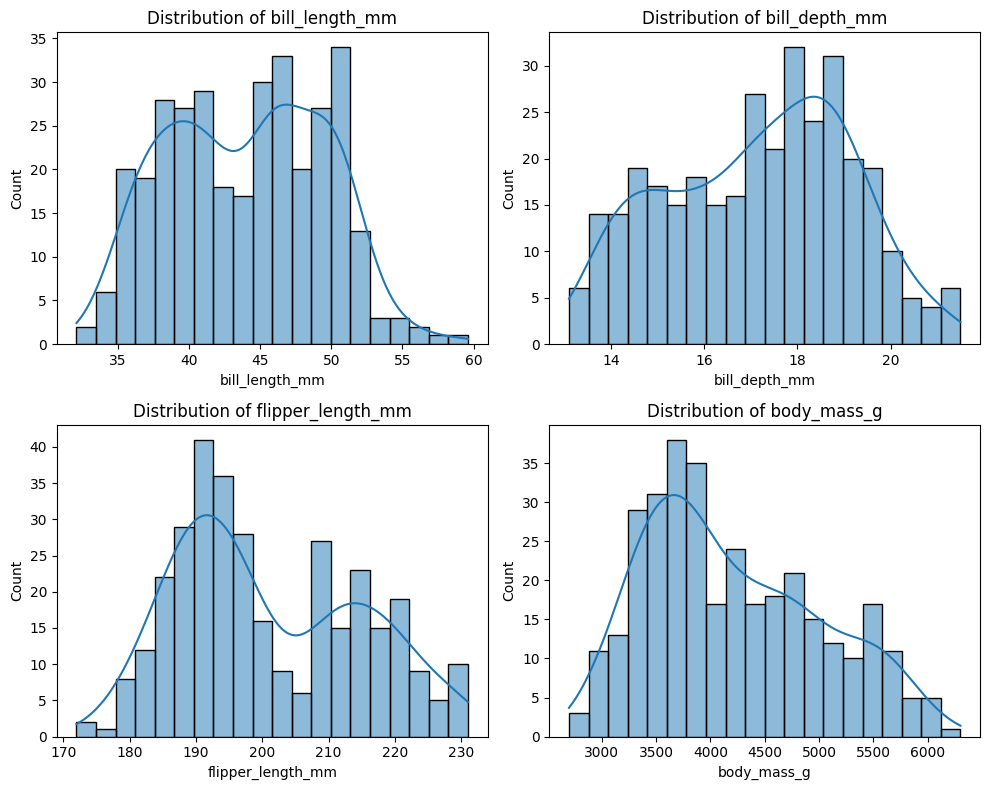

In [48]:
viz = Visualizer()
_ = viz.plot_distributions(df_clean)

- **`Visualizer.plot_correlation_heatmap(df)`**  
  Correlation matrix (**numeric columns only**) with annotations.  
  Positive values indicate features that tend to increase together; negative values move in opposite directions.

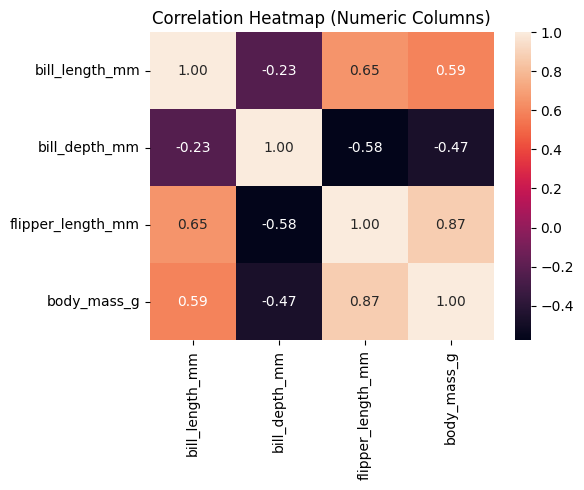

In [49]:
_ = viz.plot_correlation_heatmap(df_clean)

## 5) K-Means + Cluster Plot

### What the ML step does
- **`Analyzer.kmeans_on_numeric(df, n_clusters=3)`**  
  Selects numeric columns, performs simple **z-score standardization**, runs **K-Means**, and returns `(model, labeled_df)` where `labeled_df` has an added `cluster` column.

- **`Visualizer.plot_kmeans_clusters(df_labeled, x, y, label_col="cluster")`**  
  2-D scatter colored by cluster. Choose any two numeric features for the axes to inspect separability.

/Users/arda/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/arda/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/arda/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


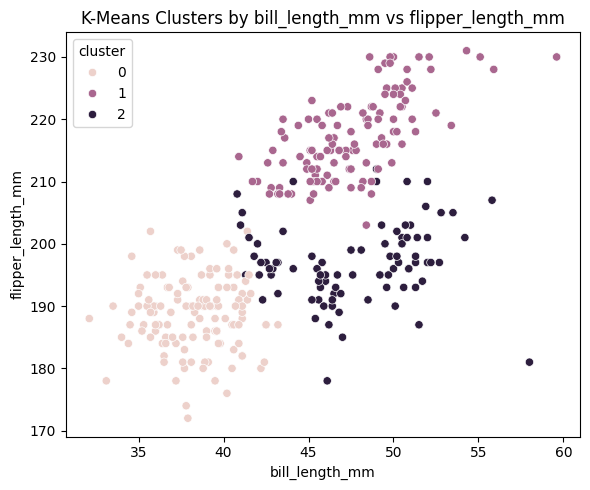

In [39]:
model, df_labeled = an.kmeans_on_numeric(df_clean, n_clusters=3)
_ = viz.plot_kmeans_clusters(df_labeled, x='bill_length_mm', y='flipper_length_mm', label_col='cluster')

## Island-wise Feature Comparison

If you added `Visualizer.plot_island_feature_distributions(...)`:

- **`plot_island_feature_distributions(df, features=None, kind="violin", add_points=True)`**  
  Facets one subplot **per feature** (e.g., mass, bill length, bill depth, flipper length) with **islands on the x-axis** to compare distributions across islands. `kind` can be `"violin"`, `"box"`, or `"boxen"`.

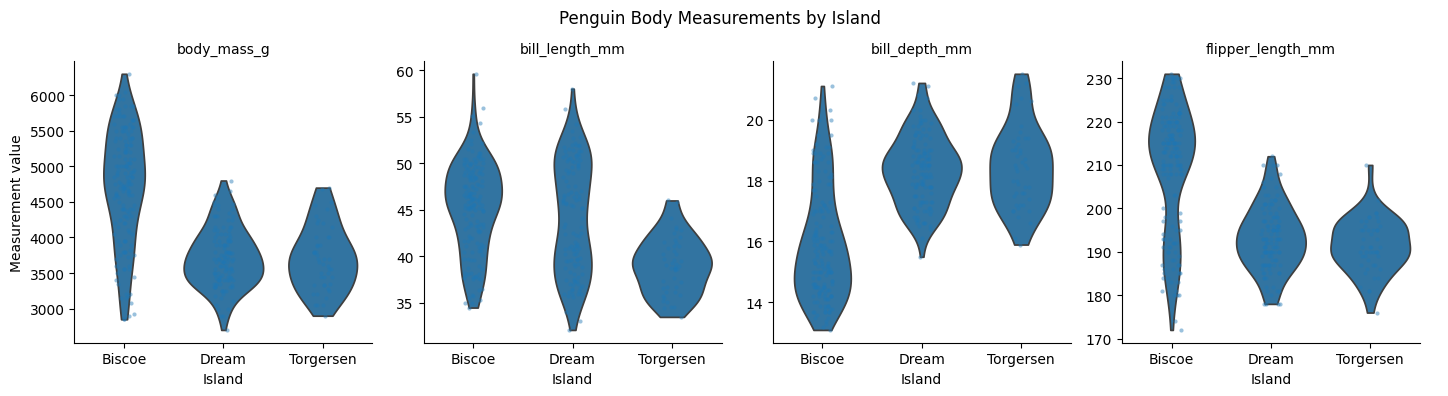

In [40]:
_ = viz.plot_island_feature_distributions(df_clean, kind="violin", add_points=True)
